In [1]:
%run ./data/data.ipynb

Pulling data from sources.json:
(Source: CBS)  deceased @ https://opendata.cbs.nl/statline/portal.html?_catalog=CBS&_la=nl&tableId=70895ned&_theme=76
(Source: CBS)  population @ https://opendata.cbs.nl/statline/portal.html?_catalog=CBS&_la=nl&tableId=37230ned&_theme=76
(Source: RIVM)  counts_per_municipality @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/5f6bc429-1596-490e-8618-1ed8fd768427
(Source: RIVM)  prevalence @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/097155aa-75eb-4caa-8ed3-4c6edb80467e
(Source: RIVM)  r @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/ed0699d1-c9d5-4436-8517-27eb993eab6e
(Source: RIVM)  homes_for_elderly @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/0179dd26-7bf6-4021-857f-8623aaf8e73a
(Source: RIVM)  homes_for_disabled @ https://data.rivm.nl/geonetwork/srv/dut/catalog.search#/metadata/aa28b74d-7150-47bc-a7cb-98876e93381b
(Source: RIVM)  seventy_plus_living_at_home @ https://da

# Check RIVM modellen
https://www.rivm.nl/coronavirus-covid-19/hoe-berekeningen-bijdragen-aan-bestrijding-van-virus/rekenmodellen

https://github.com/lo-hfk/epyestim

## Tried covid-seird = False
https://github.com/pblins/covid_seird

Not able to load custom data

## trying SEIR
https://pypi.org/project/SEIR/

In [2]:
import os
import sys
import click
import numpy as np
import seaborn as sns
import datetime

from SEIR.seir import SEIR
from SEIR.visualization import visualize_seir_computation

from matplotlib import rcParams
rcParams['figure.figsize'] = 20,10

In [3]:
visualize_compartments = False
output_file_format = 'csv'
#output_file_format = 'json'
output_file = './data/csvs/seir.'+output_file_format

In [4]:
# Define model
def run_model(action=None):
    model = SEIR(
        incubation_period=incubation_period,
        infectious_period=infectious_period,
        initial_R0=initial_R0,
        hospitalization_probability=hospitalization_probability,
        hospitalization_duration=hospitalization_duration,
        hospitalization_lag_from_onset=hospitalization_lag_from_onset,
        icu_probability=icu_probability,
        icu_duration=icu_duration,
        icu_lag_from_onset=icu_lag_from_onset,
        death_probability=death_probability,
        death_lag_from_onset=death_lag_from_onset,
        population=population,
        compartments = compartments,
        contacts_matrix = contacts_matrix,
        restrictions_function = restrictions_function,
        imported_cases_function = imported_cases_function
    )
    
    model.set_initial_state(
        population_exposed = population_exposed,
        population_infected = population_infected,
        probabilities = probabilities
    )
    
    model.simulate(
        max_simulation_time = max_simulation_time,
        method = method,
        max_step = max_step
    )
    
    # Evaluate the solution
    time = np.arange(0, max_simulation_time, 1, dtype=int)
    global results
    results = model.evaluate_solution(time)
    
    # Visualize the results
    if action == 'show':
        visualize_seir_computation(
            results,
            compartments=compartments,
            restrictions_info=restr_info,
            show_individual_compartments=visualize_compartments
        )
    elif action == 'save':
        if output_file_format == 'csv':
            results.to_csv(output_file)
        elif output_file_format == 'json':
            results.to_json(output_file)
    else:
        return results

### Setup the model

In [5]:
incubation_period = 3
infectious_period = 7
initial_R0 = 1
hospitalization_probability = 0.1
hospitalization_duration = 20
hospitalization_lag_from_onset = 7
icu_probability = 0.01
icu_duration = 10
icu_lag_from_onset = 11
death_probability = 0.1
death_lag_from_onset = 25
population = 17e6

In [6]:
compartments = None #Optional[List[Any]]
contacts_matrix = None # Optional[numpy.ndarray]
restrictions_function = None # Optional[Callable[[float], Union[float, numpy.ndarray]]]
imported_cases_function = None # Optional[Callable]

In [7]:
restr_info = ''

#[restriction everyone-begin-careful]
#day-begins = 20
#day-ends = 180
#infectivity modifier = 0.7

#[restriction school-closure]
#day-begins = 40
#day-ends = 100
#infectivity modifier = 
#   [5-9, 10-14, 15-19] : [5-9, 10-14, 15-19] : 0.5714
#   all : [65-69, 70+] : 0.7143

#[restriction random-efforts]
#day-begins = 1
#day-ends = 180
#infectivity modifier = file://infectivity_modifier_matrix_example.csv

In [8]:
# Setup initial state
population_exposed = 0.005
population_infected = 0.005
probabilities = True

# Simulate up to 200 days
max_simulation_time = 200
method = 'DOP853'
max_step = 0.5

### Execute model

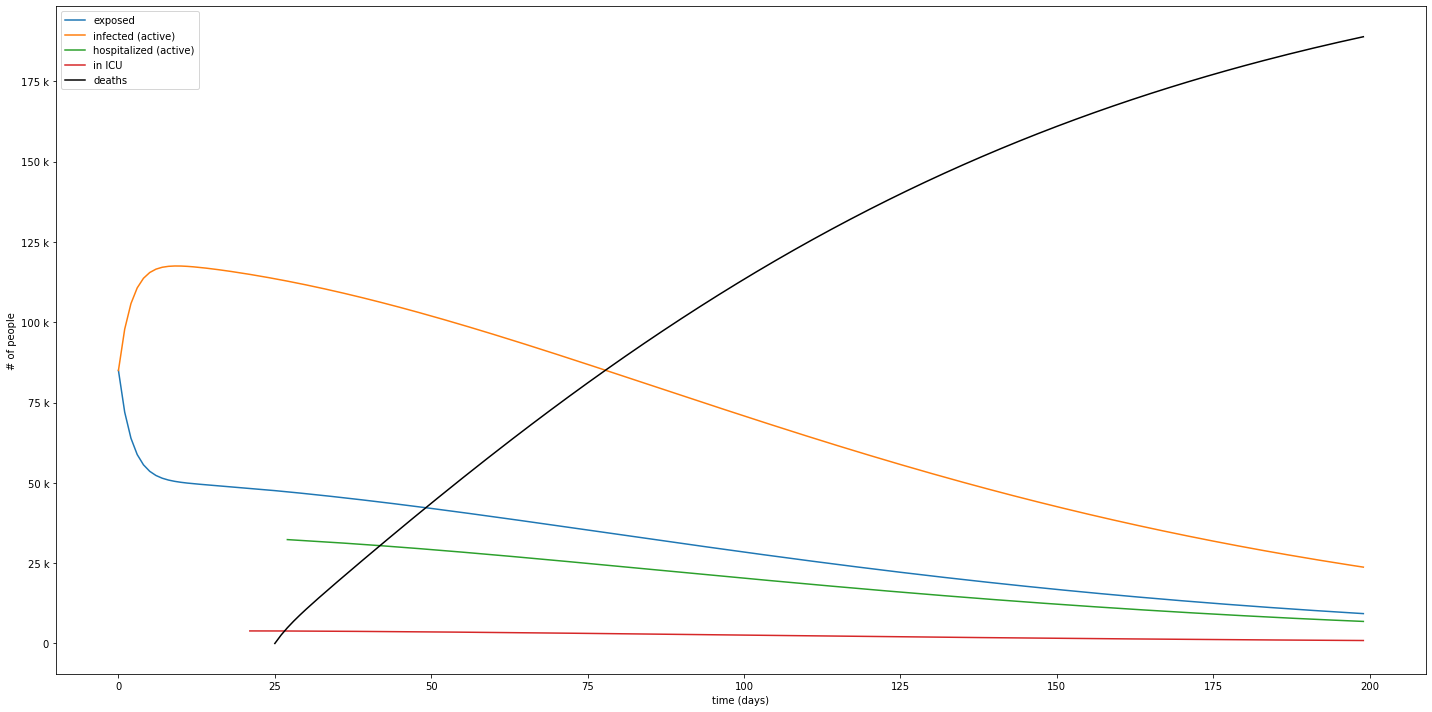

In [9]:
run_model('show')

### insert own data

In [10]:
# https://www.rivm.nl/coronavirus-covid-19/ziekte:
## Als je besmet raakt duurt het meestal 5 tot 6 dagen voordat je klachten krijgt.
incubation_period = 5
# https://amazingerasmusmc.nl/biomedisch/hoelang-is-een-covid-19-patient-besmettelijk:
## We hebben aangetoond dat ernstig zieke covid-19-patienten tot zo’n vijftien dagen infectieus kunnen zijn.
## De meeste gegevens die tot nu toe werden gepubliceerd, zijn gebaseerd op metingen bij patiënten met milde klachten. Dan wordt uitgegaan van een dag of tien.
# https://www.gezondheidenwetenschap.be/gezondheid-in-de-media/wanneer-is-iemand-met-covid-19-het-meest-besmettelijk:
## In geen enkele studie konden onderzoekers nog levend virus aantonen 9 dagen na de start van de symptomen.
infectious_period = 9

initial_R0 = r['Rt_avg'][0]
print('initial_R0 = '+str(initial_R0))

hospitalization_probability = rivm_per_day['Hospital_admission_NICE'].sum()/rivm_per_day['Positive_tests'].sum()
print('hospitalization_probability until now = '+str(round(hospitalization_probability,4)))
icu_probability = rivm_per_day['IC_admission'].sum()/rivm_per_day['Positive_tests'].sum()
print('icu_probability = '+str(round(icu_probability,4)))
death_probability = rivm_per_day['Deceased_covid'].sum()/rivm_per_day['Positive_tests'].sum()
print('death_probability = '+str(round(death_probability,4)))

# https://www.rtlnieuws.nl/economie/artikel/5196644/corona-behandeling-kosten-testen-huisarts-intensive-care-totaal:
## Uit onderzoek van de Nederlandse Internisten Vereniging (NIV) komt naar voren dat een coronapatiënt gemiddeld zeven dagen op de verpleegafdeling ligt en/of dertien dagen op de intensive care.
hospitalization_duration = 7
icu_duration = 13

# https://wibnet.nl/geneeskunde/ziektes/van-dag-tot-dag-zo-neemt-het-coronavirus-je-lichaam-over:
## Na zeven dagen worden patiënten met ernstige klachten opgenomen in het ziekenhuis.
## Als de toestand verslechtert of als er nog meer organen uitvallen, wordt de patiënt na 10 dagen meestal opgenomen op de intensive care.
hospitalization_lag_from_onset = 7
icu_lag_from_onset = 10

# https://www.stichting-nice.nl/covid-19-op-de-ic.jsp:
## Verdeling overleden in ziekenhuis is vlakker dan levend uit ziekenhuis, doet gemiddelde verschuiven. standaard van model is 25 dagen. laat ik zo
death_lag_from_onset = 25

# Setup initial state
ni = 36
e = str(rivm_per_day.index[ni].year * 100 + rivm_per_day.index[ni].month)
e = e[:4] + '-' + e[-2:]
population_exposed = rivm_per_day.loc[rivm_per_day.index[ni],'Positive_tests'].sum() / population_per_month.loc[e,'Population']
population_infected = rivm_per_day.loc[rivm_per_day.index[ni],'prev_avg'].sum() / population_per_month.loc[e,'Population']

initial_R0 = 1.93
hospitalization_probability until now = 0.0311
icu_probability = 0.0059
death_probability = 0.0075


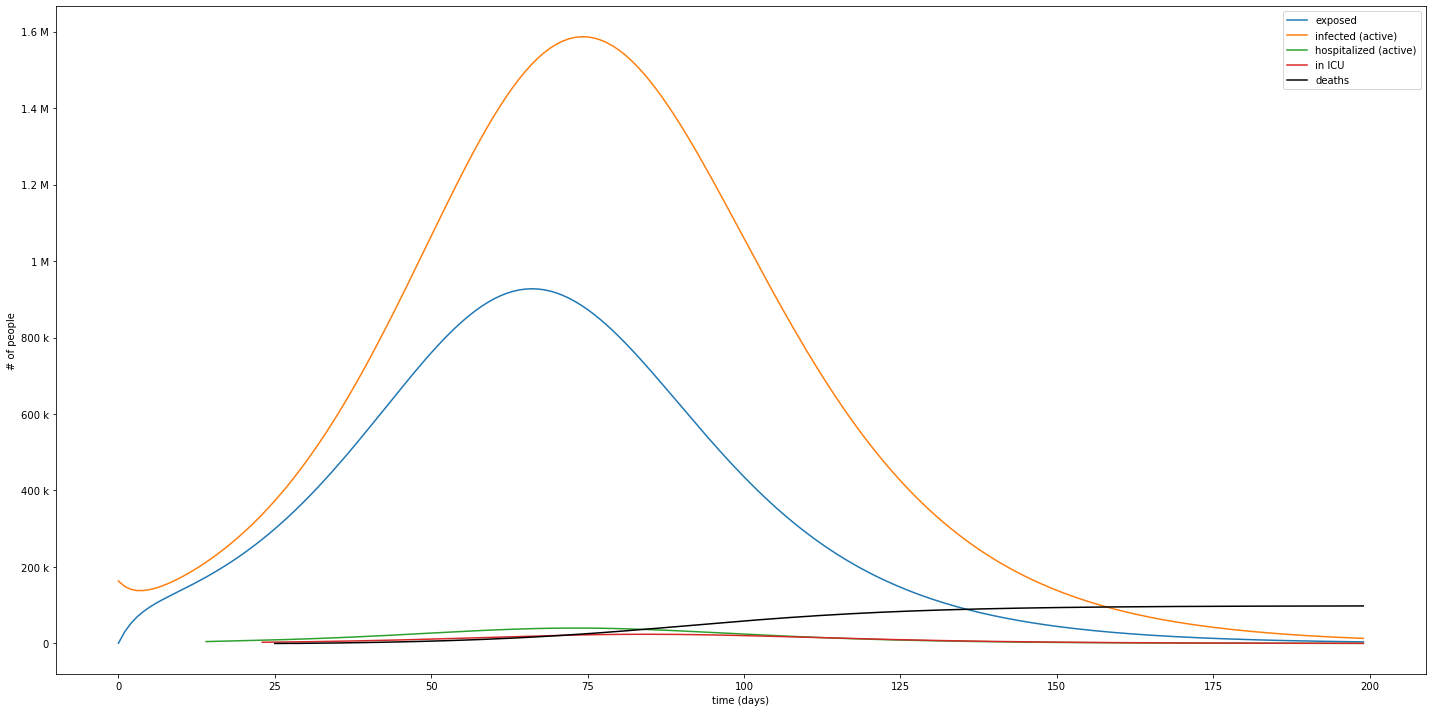

In [11]:
run_model('show')

In [12]:
results.head()

,time,"(susceptible, All)",susceptible,"(exposed, All)",exposed,"(infected (active), All)",infected (active),"(infected (total), All)",infected (total),"(removed, All)",removed,"(hospitalized (active), All)",hospitalized (active),"(in ICU, All)",in ICU,"(deaths, All)",deaths
0,0.0,1.683609e+07,1.683609e+07,730.762867,730.762867,163182.567842,163182.567842,163182.567842,163182.567842,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.680308e+07,1.680308e+07,30464.890599,30464.890599,149168.059764,149168.059764,166302.133189,166302.133189,17283.481003,17283.481003,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.677240e+07,1.677240e+07,52726.275792,52726.275792,141490.498668,141490.498668,174621.249828,174621.249828,33382.158813,33382.158813,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1.674289e+07,1.674289e+07,69901.210942,69901.210942,138312.771828,138312.771828,186883.998501,186883.998501,48891.781997,48891.781997,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,1.671375e+07,1.671375e+07,83644.377937,83644.377937,138367.877423,138367.877423,202238.557389,202238.557389,64237.585259,64237.585259,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df = pd.DataFrame()
n=0
max_simulation_time = 60
for i in rivm_per_day.index:
    try:
        r['Rt_avg'][i]
    except:
        pass
    else:
        initial_R0 = r['Rt_avg'][i]
        hospitalization_probability = rivm_per_day['Hospital_admission_NICE'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
        icu_probability = rivm_per_day['IC_admission'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
        death_probability = rivm_per_day['Deceased_covid'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
        p = str(rivm_per_day.index[ni].year * 100 + rivm_per_day.index[ni].month)
        p = e[:4] + '-' + e[-2:]
        population = population_per_month.loc[p,'Population']
        # Setup initial state
        population_exposed = rivm_per_day.loc[i + pd.Timedelta(days=-7):i,'Positive_tests'].sum() / population
        population_infected = rivm_per_day.loc[i + pd.Timedelta(days=-7):i,'prev_avg'].sum() / population
        probabilities = True

        run_model()
        results['time'] = results[ 'time'].astype(int)
        results['i'] = i
        results['time'] = results.apply(lambda x: x['i'] + pd.Timedelta(days=x['time']), axis=1)
        results['time'] = results['time'].astype(str)
        n+=1
        df = df.append(results)
df.reset_index(inplace=True, drop=True)
df

/tmp/ipykernel_1593/3125464284.py:11: RuntimeWarning: invalid value encountered in double_scalars
  hospitalization_probability = rivm_per_day['Hospital_admission_NICE'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
/tmp/ipykernel_1593/3125464284.py:12: RuntimeWarning: invalid value encountered in double_scalars
  icu_probability = rivm_per_day['IC_admission'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
/tmp/ipykernel_1593/3125464284.py:13: RuntimeWarning: invalid value encountered in double_scalars
  death_probability = rivm_per_day['Deceased_covid'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
/tmp/ipykernel_1593/3125464284.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  hospitalization_probability = rivm_per_day['Hospital_admission_NICE'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
/home/cjvanzwol/miniconda3/envs/covid/lib/python3.9/site-packages/SEIR/seir.py:507: RuntimeWarning: invalid value encountered in multiply
  np.multiply(self.

,time,"(susceptible, All)",susceptible,"(exposed, All)",exposed,"(infected (active), All)",infected (active),"(infected (total), All)",infected (total),"(removed, All)",removed,"(hospitalized (active), All)",hospitalized (active),"(in ICU, All)",in ICU,"(deaths, All)",deaths,i
0,2020-02-17,1.742318e+07,1.742318e+07,0.000000,0.000000,1074.000000,1074.000000,1074.000000,1074.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-17
1,2020-02-18,1.742296e+07,1.742296e+07,198.598014,198.598014,981.139323,981.139323,1093.859801,1093.859801,113.712093,113.712093,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-17
2,2020-02-19,1.742276e+07,1.742276e+07,347.627948,347.627948,930.559724,930.559724,1148.482398,1148.482398,219.590268,219.590268,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-17
3,2020-02-20,1.742256e+07,1.742256e+07,462.993813,462.993813,910.056466,910.056466,1229.544574,1229.544574,321.612467,321.612467,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-17
4,2020-02-21,1.742237e+07,1.742237e+07,555.748336,555.748336,911.223013,911.223013,1331.418789,1331.418789,422.624424,422.624424,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38095,2022-01-06,1.732188e+07,1.732188e+07,1.709837,1.709837,507.074862,507.074862,102714.307184,102714.307184,101866.215301,101866.215301,0.352911,0.352911,27.683286,27.683286,844.076517,844.076517,2021-11-12
38096,2022-01-07,1.732188e+07,1.732188e+07,1.399896,1.399896,454.043323,454.043323,102714.618157,102714.618157,101919.556781,101919.556781,0.288939,0.288939,24.950033,24.950033,844.456721,844.456721,2021-11-12
38097,2022-01-08,1.732188e+07,1.732188e+07,1.146138,1.146138,406.535541,406.535541,102714.872761,102714.872761,101967.318321,101967.318321,0.240359,0.240359,22.495870,22.495870,844.768006,844.768006,2021-11-12
38098,2022-01-09,1.732188e+07,1.732188e+07,0.938378,0.938378,363.980255,363.980255,102715.081212,102715.081212,102010.081366,102010.081366,0.200585,0.200585,20.292959,20.292959,845.022864,845.022864,2021-11-12


In [ ]:
rcParams['figure.figsize'] = 20,100
df.plot(subplots=True,kind='bar')

In [ ]:
sns.relplot(
    data=df,
    x="time", y="exposed",
    hue="i",
    kind="line",
    height=10, aspect=1.5, 
    facet_kws=dict(sharex=False),
    legend=False
)

In [ ]:
sns.set_theme(style="ticks")

for c in df.columns:
    if c.__contains__('All') or c.__contains__('time') or c.__contains__('i'):
        pass
    else:
        # Plot the lines on two facets
        sns.relplot(
            data=df,
            x="time", y=c,
            hue="i",
            kind="line",
            height=10, aspect=1.5, 
            facet_kws=dict(sharex=False),
            legend=False
        )

In [ ]:
df2 = pd.DataFrame()
n=0
max_simulation_time = 60
for i in rivm_per_day.index:
    try:
        r['Rt_avg'][i]
    except:
        pass
    else:
        f = i + pd.Timedelta(days=-max_simulation_time)
        initial_R0 = r['Rt_avg'][i]
        hospitalization_probability = rivm_per_day['Hospital_admission_NICE'][:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
        icu_probability = rivm_per_day['IC_admission'][f:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
        death_probability = rivm_per_day['Deceased_covid'][f:i].sum()/rivm_per_day['Positive_tests'][:i].sum()
        p = str(rivm_per_day.index[ni].year * 100 + rivm_per_day.index[ni].month)
        p = e[:4] + '-' + e[-2:]
        population = population_per_month.loc[p,'Population']
        # Setup initial state
        population_exposed = rivm_per_day.loc[i + pd.Timedelta(days=-7):i,'Positive_tests'].sum() / population
        population_infected = rivm_per_day.loc[i + pd.Timedelta(days=-7):i,'prev_avg'].sum() / population
        probabilities = True

        run_model()
        results['time'] = results[ 'time'].astype(int)
        results['i'] = i
        results['time'] = results.apply(lambda x: x['i'] + pd.Timedelta(days=x['time']), axis=1)
        results['time'] = results['time'].astype(str)
        n+=1
        df2 = df2.append(results)
df2.reset_index(inplace=True, drop=True)
df2

In [ ]:
for c in df.columns:
    if c.__contains__('All') or c.__contains__('time') or c.__contains__('i'):
        pass
    else:
        df[c].plot()

In [ ]:
for c in df2.columns:
    if c.__contains__('All') or c.__contains__('time'):
        pass
    else:
        # Plot the lines on two facets
        sns.relplot(
            data=df2,
            x="time", y=c,
            hue="i",
            kind="line",
            height=10, aspect=1.5, 
            facet_kws=dict(sharex=False),
            legend=False
        )

## trying epintervene
https://github.com/andrea-allen/epintervene

In [ ]:
import epintervene